In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, Flatten, BatchNormalization, Input ,concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import  EarlyStopping, ModelCheckpoint
import glob
import os
import PIL
import time

from IPython import display

In [3]:
# Load the data
X_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIFT+GAN handwriting/ahds/csvTrainImages 60k x 784.csv")
Y_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIFT+GAN handwriting/ahds/csvTrainLabel 60k x 1.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIFT+GAN handwriting/ahds/csvTestImages 10k x 784.csv")
y_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIFT+GAN handwriting/ahds/csvTestLabel 10k x 1.csv")
print(X_train.shape)
print(Y_train.shape)
print(test.shape)
print(y_test.shape)

(59999, 784)
(59999, 1)
(9999, 784)
(9999, 1)


In [4]:
Y_train = Y_train.values.reshape(Y_train.shape[0],).astype('float32')
Y_train.shape

(59999,)

In [5]:
X_train = X_train.values.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
np.random.seed(42)
trainsize = 30000  # number of training images we use, selected randomly
randtrain = np.random.choice(X_train.shape[0], trainsize, replace=False)
X_train, Y_train = X_train[randtrain], Y_train[randtrain]

In [6]:
X_train = (X_train - 127.5) / 127.5 # Normalize the images to [-1, 1]


BUFFER_SIZE = trainsize
BATCH_SIZE = 100
g_loss = []
d_loss = []

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

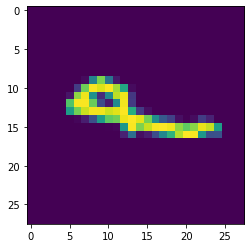

In [ ]:
# demonstrate an image
plt.figure()
plt.imshow(X_train[0].reshape( 28, 28))
plt.show()

<Figure size 432x288 with 0 Axes>

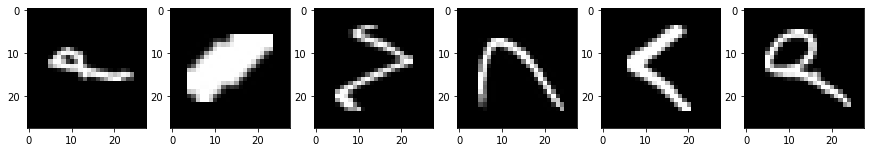

In [25]:
plt.figure()
f, axarr = plt.subplots(1,6, figsize=(15, 15)) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(X_train[0].reshape( 28, 28), cmap='gray')
axarr[1].imshow(X_train[13].reshape( 28, 28), cmap='gray')
axarr[2].imshow(X_train[21].reshape( 28, 28), cmap='gray')
axarr[3].imshow(X_train[6].reshape( 28, 28), cmap='gray')
axarr[4].imshow(X_train[60].reshape( 28, 28), cmap='gray')
axarr[5].imshow(X_train[11].reshape( 28, 28), cmap='gray')

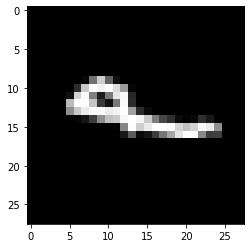

In [ ]:
# demonstrate an image
plt.figure()
plt.imshow(X_train[0].reshape( 28, 28), cmap='gray')
plt.show()

In [ ]:
len(np.unique(Y_train))

10

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

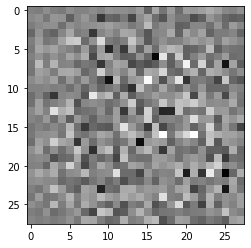

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00088499]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output, d_loss):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    d_loss.append(total_loss)
    return total_loss
def generator_loss(fake_output, g_loss):
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    g_loss.append(fake_loss)
    return fake_loss
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/SIFT+GAN handwriting/training_checkpoints_ahsd'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 95
noise_dim = 100
num_examples_to_generate = 9

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
import tqdm.notebook as tqdm
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# @tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output, g_loss)
      disc_loss = discriminator_loss(real_output, fake_output, d_loss)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    
def train(dataset, epochs):
  
  for epoch in range(epochs):
    start = time.time()

    for image_batch in tqdm.tqdm(dataset, desc="Epoch: "+str(epoch+1)):
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(3, 3, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

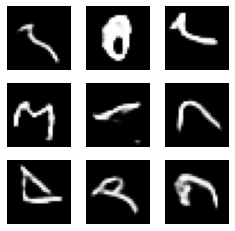

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

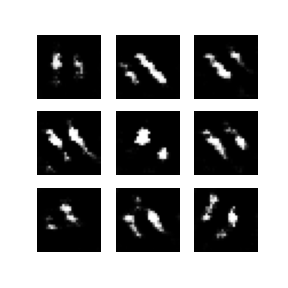

In [ ]:
display_image(5)

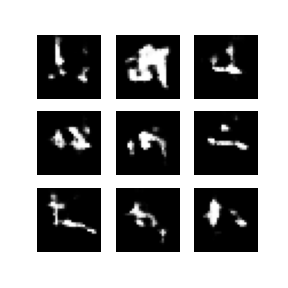

In [ ]:
display_image(20)

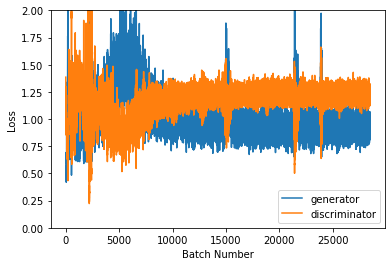

In [ ]:
plt.figure()
plt.plot(g_loss, label='generator')
plt.plot(d_loss, label = 'discriminator')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='lower right')
plt.show()

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

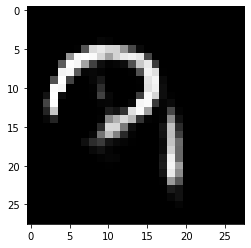

In [ ]:
# generate a new image from the trained generator
noi = tf.random.normal([1, 100])
sample = checkpoint.generator(noi, training=False)
plt.imshow(sample[0, :, :, 0], cmap='gray')

In [ ]:
# detect the image using the trained discriminator
val = checkpoint.discriminator(sample)
print (val)

tf.Tensor([[0.01294644]], shape=(1, 1), dtype=float32)


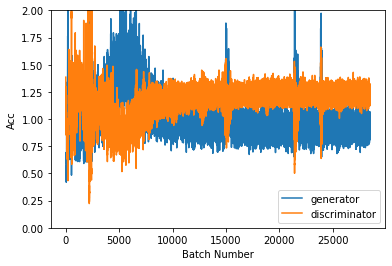

In [ ]:
plt.figure()
plt.plot(g_loss, label='generator')
plt.plot(d_loss, label = 'discriminator')
plt.xlabel('Batch Number')
plt.ylabel('Acc')
plt.ylim([0, 2])
plt.legend(loc='lower right')
plt.show()